# Read Data

In [1]:
import pandas as pd

# Read the CSV file into a DataFrame
df = pd.read_csv('SOL_USDT_futures_data_2020.csv')

# Drop unnecessary columns
df.drop(columns=(['coin','volume','closetime','quotevolume','trades','taker_buy_volume','taker_buy_quote','unused']), inplace=True)

# Display the first few rows of the DataFrame
df

,opentime,openprice,highprice,lowprice,closeprice
0,1600066800000,3.2002,4.9100,3.2002,3.3666
1,1600070400000,3.3663,3.5650,3.3000,3.3298
2,1600074000000,3.3298,3.3567,3.2161,3.2755
3,1600077600000,3.2753,3.3873,3.2500,3.3673
4,1600081200000,3.3686,3.4600,3.3200,3.3799
...,...,...,...,...,...
37649,1735603200000,191.2600,191.9600,189.9000,189.9800
37650,1735606800000,189.9900,190.3600,188.2400,189.1000
37651,1735610400000,189.1000,190.7500,188.7100,190.1900
37652,1735614000000,190.1900,190.6900,189.3900,189.8400


# Super Trend Indicator Function

In [4]:
import pandas as pd
import numpy as np
from pandas_ta.overlap import hl2
from pandas_ta.volatility import atr
from pandas_ta.utils import get_offset, verify_series

# npNaN = np.nan

# Apply the Supertrend function
def supertrend(high, low, close, length=7, multiplier=3.0, offset=0, **kwargs):
    """Indicator: Supertrend"""
    # Validate Arguments
    high = verify_series(high, length)
    low = verify_series(low, length)
    close = verify_series(close, length)
    offset = get_offset(offset)

    if high is None or low is None or close is None:
        return

    m = close.size
    dir_, trend = [1] * m, [0] * m
    long, short = [np.nan] * m, [np.nan] * m

    hl2_ = hl2(high, low)
    matr = multiplier * atr(high, low, close, length)
    upperband = hl2_ + matr
    lowerband = hl2_ - matr

    for i in range(1, m):
        if close.iloc[i] > upperband.iloc[i - 1]:
            dir_[i] = 1
        elif close.iloc[i] < lowerband.iloc[i - 1]:
            dir_[i] = -1
        else:
            dir_[i] = dir_[i - 1]
            if dir_[i] > 0 and lowerband.iloc[i] < lowerband.iloc[i - 1]:
                lowerband.iloc[i] = lowerband.iloc[i - 1]
            if dir_[i] < 0 and upperband.iloc[i] > upperband.iloc[i - 1]:
                upperband.iloc[i] = upperband.iloc[i - 1]

        if dir_[i] > 0:
            trend[i] = long[i] = lowerband.iloc[i]
        else:
            trend[i] = short[i] = upperband.iloc[i]

    # Prepare DataFrame to return
    _props = f"_{length}_{multiplier}"
    df = pd.DataFrame({
        f"SUPERT{_props}": trend,
        f"SUPERTd{_props}": dir_,
        f"SUPERTl{_props}": long,
        f"SUPERTs{_props}": short,
    }, index=close.index)

    df.name = f"SUPERT{_props}"
    df.category = "overlap"

    # Apply offset if needed
    if offset != 0:
        df = df.shift(offset)

    # Handle fills
    if "fillna" in kwargs:
        df.fillna(kwargs["fillna"], inplace=True)

    if "fill_method" in kwargs:
        df.fillna(method=kwargs["fill_method"], inplace=True)

    return df

# 3 Stacked Super Trend

1. length = 12, multiplier = 3
2. length = 11, multiplier = 2
1. length = 10, multiplier = 1

In [92]:
# Get the Supertrend values using the 'highprice', 'lowprice', and 'closeprice' columns
supertrend_indicator_1 = supertrend(df['highprice'], df['lowprice'], df['closeprice'], length=12, multiplier=3.0)
supertrend_indicator_2 = supertrend(df['highprice'], df['lowprice'], df['closeprice'], length=11, multiplier=2.0)
supertrend_indicator_3 = supertrend(df['highprice'], df['lowprice'], df['closeprice'], length=10, multiplier=1.0)

# Join the Supertrend indicator values to your original dataframe
supertrend_df = df.join(supertrend_indicator_1)
supertrend_df = supertrend_df.join(supertrend_indicator_2)
supertrend_df = supertrend_df.join(supertrend_indicator_3)

# Drop unnecessary columns
supertrend_df.drop(columns=(['SUPERT_12_3.0','SUPERTd_12_3.0','SUPERT_11_2.0','SUPERTd_11_2.0','SUPERT_10_1.0','SUPERTd_10_1.0']), inplace=True)

# Check the output
supertrend_df

,opentime,openprice,highprice,lowprice,closeprice,SUPERTl_12_3.0,SUPERTs_12_3.0,SUPERTl_11_2.0,SUPERTs_11_2.0,SUPERTl_10_1.0,SUPERTs_10_1.0
0,1600066800000,3.2002,4.9100,3.2002,3.3666,NaN,NaN,NaN,NaN,NaN,NaN
1,1600070400000,3.3663,3.5650,3.3000,3.3298,NaN,NaN,NaN,NaN,NaN,NaN
2,1600074000000,3.3298,3.3567,3.2161,3.2755,NaN,NaN,NaN,NaN,NaN,NaN
3,1600077600000,3.2753,3.3873,3.2500,3.3673,NaN,NaN,NaN,NaN,NaN,NaN
4,1600081200000,3.3686,3.4600,3.3200,3.3799,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
37649,1735603200000,191.2600,191.9600,189.9000,189.9800,187.486581,NaN,NaN,196.296492,NaN,193.432177
37650,1735606800000,189.9900,190.3600,188.2400,189.1000,187.486581,NaN,NaN,194.754456,NaN,192.041507
37651,1735610400000,189.1000,190.7500,188.7100,190.1900,187.486581,NaN,NaN,194.754456,NaN,192.041507
37652,1735614000000,190.1900,190.6900,189.3900,189.8400,187.486581,NaN,NaN,194.754456,NaN,192.041507


1. length = 10, multiplier = 3
2. length = 10, multiplier = 1

In [5]:
# Get the Supertrend values using the 'highprice', 'lowprice', and 'closeprice' columns
supertrend_indicator_1 = supertrend(df['highprice'], df['lowprice'], df['closeprice'], length=10, multiplier=3.0)
supertrend_indicator_2 = supertrend(df['highprice'], df['lowprice'], df['closeprice'], length=10, multiplier=1.0)

# Join the Supertrend indicator values to your original dataframe
supertrend_df = df.join(supertrend_indicator_1)
supertrend_df = supertrend_df.join(supertrend_indicator_2)

# Drop unnecessary columns
supertrend_df.drop(columns=(['SUPERT_10_3.0','SUPERTd_10_3.0','SUPERT_10_1.0','SUPERTd_10_1.0']), inplace=True)

# Check the output
supertrend_df

,opentime,openprice,highprice,lowprice,closeprice,SUPERTl_10_3.0,SUPERTs_10_3.0,SUPERTl_10_1.0,SUPERTs_10_1.0
0,1600066800000,3.2002,4.9100,3.2002,3.3666,NaN,NaN,NaN,NaN
1,1600070400000,3.3663,3.5650,3.3000,3.3298,NaN,NaN,NaN,NaN
2,1600074000000,3.3298,3.3567,3.2161,3.2755,NaN,NaN,NaN,NaN
3,1600077600000,3.2753,3.3873,3.2500,3.3673,NaN,NaN,NaN,NaN
4,1600081200000,3.3686,3.4600,3.3200,3.3799,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
37649,1735603200000,191.2600,191.9600,189.9000,189.9800,187.28879,NaN,NaN,193.432177
37650,1735606800000,189.9900,190.3600,188.2400,189.1000,187.28879,NaN,NaN,192.041507
37651,1735610400000,189.1000,190.7500,188.7100,190.1900,187.28879,NaN,NaN,192.041507
37652,1735614000000,190.1900,190.6900,189.3900,189.8400,187.28879,NaN,NaN,192.041507


In [6]:
supertrend_df_sample = supertrend_df.tail(100)
supertrend_df_sample

,opentime,openprice,highprice,lowprice,closeprice,SUPERTl_10_3.0,SUPERTs_10_3.0,SUPERTl_10_1.0,SUPERTs_10_1.0
37554,1735261200000,189.03,189.87,188.16,188.89,NaN,194.722342,NaN,190.308136
37555,1735264800000,188.89,190.33,187.94,188.74,NaN,194.722342,NaN,190.308136
37556,1735268400000,188.74,189.76,188.30,189.35,NaN,194.722342,NaN,190.308136
37557,1735272000000,189.34,190.72,189.29,189.65,NaN,194.722342,NaN,190.308136
37558,1735275600000,189.66,189.96,187.80,189.11,NaN,194.722342,NaN,190.308136
...,...,...,...,...,...,...,...,...,...
37649,1735603200000,191.26,191.96,189.90,189.98,187.28879,NaN,NaN,193.432177
37650,1735606800000,189.99,190.36,188.24,189.10,187.28879,NaN,NaN,192.041507
37651,1735610400000,189.10,190.75,188.71,190.19,187.28879,NaN,NaN,192.041507
37652,1735614000000,190.19,190.69,189.39,189.84,187.28879,NaN,NaN,192.041507


/tmp/ipykernel_509969/4212868632.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  supertrend_df_sample['opentime'] = pd.to_datetime(supertrend_df_sample['opentime'], unit='ms')
/tmp/ipykernel_509969/4212868632.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  supertrend_df_sample['date_num'] = mdates.date2num(supertrend_df_sample['opentime'])


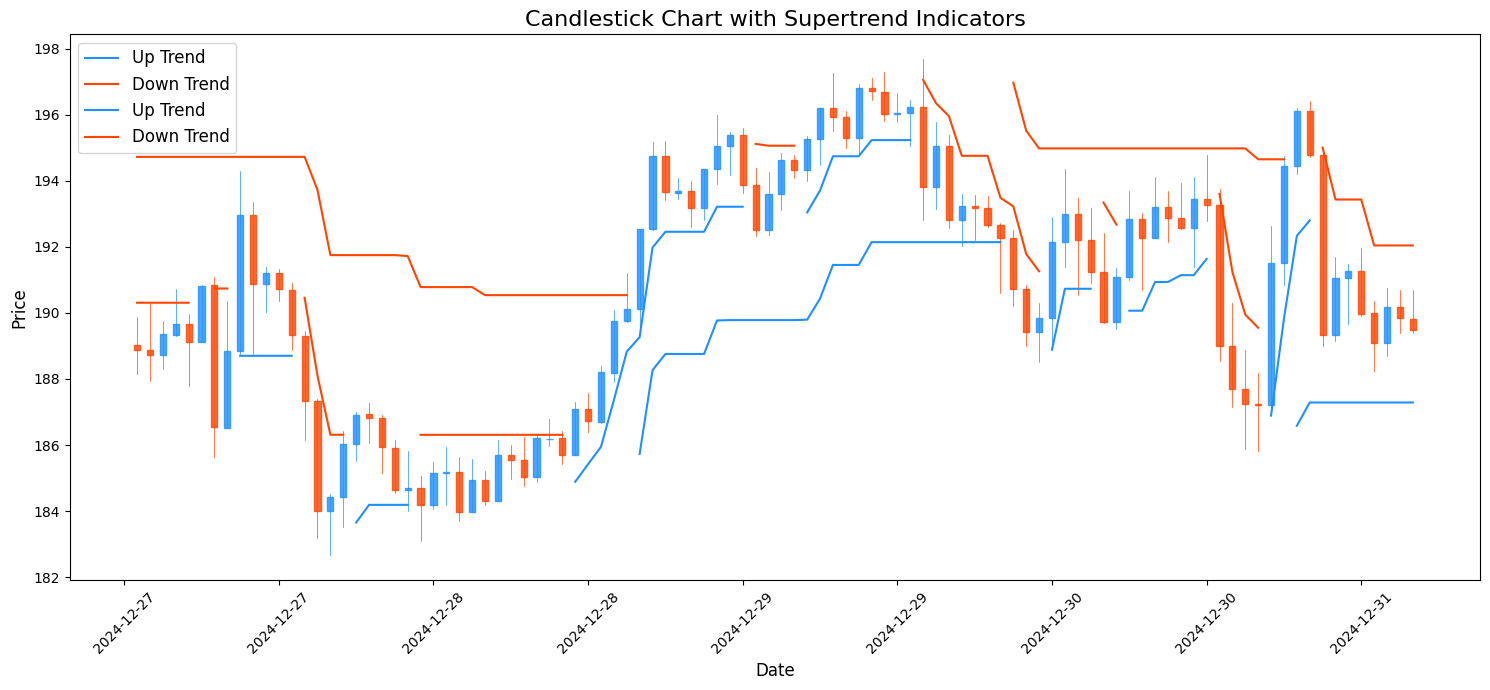

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mdates

# Assuming `supertrend_df` is already loaded
# Convert 'opentime' to datetime and set up plotting data
supertrend_df_sample['opentime'] = pd.to_datetime(supertrend_df_sample['opentime'], unit='ms')
supertrend_df_sample['date_num'] = mdates.date2num(supertrend_df_sample['opentime'])

# Prepare OHLC data for candlestick plot
ohlc = supertrend_df_sample[['date_num', 'openprice', 'highprice', 'lowprice', 'closeprice']].dropna().values

# Plot configuration
fig, ax = plt.subplots(figsize=(15, 7))
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.title('Candlestick Chart with Supertrend Indicators', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)

# Plot candlestick chart
candlestick_ohlc(ax, ohlc, width=0.02, colorup='dodgerblue', colordown='orangered', alpha=0.8)

# Plot SUPERTl_10_3.0 (green) and SUPERTs_10_3.0 (red)
ax.plot(supertrend_df_sample['date_num'], supertrend_df_sample['SUPERTl_10_3.0'], color='dodgerblue', label='Up Trend')
ax.plot(supertrend_df_sample['date_num'], supertrend_df_sample['SUPERTs_10_3.0'], color='orangered', label='Down Trend')

# ax.plot(supertrend_df_sample['date_num'], supertrend_df_sample['SUPERTl_11_2.0'], color='dodgerblue', label='Up Trend')
# ax.plot(supertrend_df_sample['date_num'], supertrend_df_sample['SUPERTs_11_2.0'], color='orangered', label='Down Trend')

ax.plot(supertrend_df_sample['date_num'], supertrend_df_sample['SUPERTl_10_1.0'], color='dodgerblue', label='Up Trend')
ax.plot(supertrend_df_sample['date_num'], supertrend_df_sample['SUPERTs_10_1.0'], color='orangered', label='Down Trend')

# Add legend
plt.legend(loc='upper left', fontsize=12)
plt.tight_layout()
plt.show()


# Backtest Signaling

In [10]:
df_backtest = supertrend_df.copy()

# Rename the last 4 columns
new_column_names = {
    'opentime': 'time',
    'openprice': 'open',
    'highprice': 'high',
    'lowprice': 'low',
    'closeprice': 'close'
    # 'SUPERTl_12_3.0': 'Up Trend 12',
    # 'SUPERTs_12_3.0': 'Down Trend 12',
    # 'SUPERTl_11_2.0': 'Up Trend 11',
    # 'SUPERTs_11_2.0': 'Down Trend 11',
    # 'SUPERTl_10_1.0': 'Up Trend 10',
    # 'SUPERTs_10_1.0': 'Down Trend 10',

}
df_backtest.rename(columns=new_column_names, inplace=True)

# Drop rows 0 to 12 becuase the longest supertrend is 12
df_backtest.drop(index=range(12), inplace=True)

df_backtest['trend_12'] = np.where(df_backtest['SUPERTl_10_3.0'].notna(), 1, 0)
# df_backtest['trend_11'] = np.where(df_backtest['SUPERTl_11_2.0'].notna(), 1, 0)
df_backtest['trend_10'] = np.where(df_backtest['SUPERTl_10_1.0'].notna(), 1, 0)

# Drop unnecessary columns
df_backtest.drop(columns=(['SUPERTl_10_3.0','SUPERTs_10_3.0','SUPERTl_10_1.0','SUPERTs_10_1.0']), inplace=True)

df_backtest.reset_index(drop=True,inplace=True)

df_backtest

,time,open,high,low,close,trend_12,trend_10
0,1600110000000,3.2878,3.3600,3.2224,3.3009,1,1
1,1600113600000,3.3012,3.3471,3.2400,3.2522,1,1
2,1600117200000,3.2505,3.2847,3.2440,3.2695,1,1
3,1600120800000,3.2694,3.3009,3.2555,3.2718,1,1
4,1600124400000,3.2718,3.3000,3.2526,3.2661,1,1
...,...,...,...,...,...,...,...
37637,1735603200000,191.2600,191.9600,189.9000,189.9800,1,0
37638,1735606800000,189.9900,190.3600,188.2400,189.1000,1,0
37639,1735610400000,189.1000,190.7500,188.7100,190.1900,1,0
37640,1735614000000,190.1900,190.6900,189.3900,189.8400,1,0


In [11]:
# Define Long/Short
df_backtest['action'] = np.where(
    (df_backtest['trend_12'] == 1) & 
    #(df_backtest['trend_11'] == 1) & 
    (df_backtest['trend_10'] == 1),
    'long',
    np.where(
        (df_backtest['trend_12'] == 0) & 
        #(df_backtest['trend_11'] == 0) & 
        (df_backtest['trend_10'] == 0),
        'short',
        None  # Default action if neither condition is met
    )
)

# Define Position Closing
df_backtest['action'] = np.where(
    (df_backtest['action'].isna()) & (df_backtest['action'].shift(1) == 'long'),
    'close_long',
    np.where(
        (df_backtest['action'].isna()) & (df_backtest['action'].shift(1) == 'short'),
        'close_short',
        df_backtest['action']  # Keep the current action if no condition is met
    )
)

df_backtest

,time,open,high,low,close,trend_12,trend_10,action
0,1600110000000,3.2878,3.3600,3.2224,3.3009,1,1,long
1,1600113600000,3.3012,3.3471,3.2400,3.2522,1,1,long
2,1600117200000,3.2505,3.2847,3.2440,3.2695,1,1,long
3,1600120800000,3.2694,3.3009,3.2555,3.2718,1,1,long
4,1600124400000,3.2718,3.3000,3.2526,3.2661,1,1,long
...,...,...,...,...,...,...,...,...
37637,1735603200000,191.2600,191.9600,189.9000,189.9800,1,0,None
37638,1735606800000,189.9900,190.3600,188.2400,189.1000,1,0,None
37639,1735610400000,189.1000,190.7500,188.7100,190.1900,1,0,None
37640,1735614000000,190.1900,190.6900,189.3900,189.8400,1,0,None


In [12]:
import pandas as pd

# Sample dataframe (assuming df_backtest is already loaded)
# Create a copy of df_backtest to avoid modifying the original DataFrame
df_transformed = df_backtest.copy()

# Initialize an empty list to store the modified rows
modified_rows = []

# Iterate over the DataFrame rows
for i in range(1, len(df_transformed)):
    # Check if the action changes from long to short or short to long
    if df_transformed.at[i, 'action'] == 'short' and df_transformed.at[i - 1, 'action'] == 'long':
        # Close the previous long position
        df_transformed.at[i - 1, 'action'] = 'close_long'
        # Duplicate the current row with action 'short'
        modified_rows.append(df_transformed.iloc[i])
        df_transformed.at[i, 'action'] = 'short'
    elif df_transformed.at[i, 'action'] == 'long' and df_transformed.at[i - 1, 'action'] == 'short':
        # Close the previous short position
        df_transformed.at[i - 1, 'action'] = 'close_short'
        # Duplicate the current row with action 'long'
        modified_rows.append(df_transformed.iloc[i])
        df_transformed.at[i, 'action'] = 'long'

# Convert the modified rows into a DataFrame
df_modified = pd.DataFrame(modified_rows)

# Concatenate the modified rows to the original DataFrame
df_backtest_updated = pd.concat([df_transformed, df_modified], ignore_index=True)

# Sort the DataFrame by time to ensure proper order
df_backtest_updated.sort_values(by='time', inplace=True)

# Reset index
df_backtest_updated.reset_index(drop=True, inplace=True)

# Display the transformed DataFrame
df_backtest_updated

,time,open,high,low,close,trend_12,trend_10,action
0,1600110000000,3.2878,3.3600,3.2224,3.3009,1,1,long
1,1600113600000,3.3012,3.3471,3.2400,3.2522,1,1,long
2,1600117200000,3.2505,3.2847,3.2440,3.2695,1,1,long
3,1600120800000,3.2694,3.3009,3.2555,3.2718,1,1,long
4,1600124400000,3.2718,3.3000,3.2526,3.2661,1,1,long
...,...,...,...,...,...,...,...,...
37705,1735603200000,191.2600,191.9600,189.9000,189.9800,1,0,None
37706,1735606800000,189.9900,190.3600,188.2400,189.1000,1,0,None
37707,1735610400000,189.1000,190.7500,188.7100,190.1900,1,0,None
37708,1735614000000,190.1900,190.6900,189.3900,189.8400,1,0,None


In [13]:
# Initialize lists to store results
long_close_pairs = []
short_close_pairs = []

# Track the previous close index
previous_close_long_idx = -1
previous_close_short_idx = -1

# Find all 'close_long' and 'close_short' indices
close_long_indices = df_backtest_updated[df_backtest_updated['action'] == 'close_long'].index
close_short_indices = df_backtest_updated[df_backtest_updated['action'] == 'close_short'].index

# For each 'close_long', find the smallest preceding 'long' greater than the previous close
for close_long_idx in close_long_indices:
    # Ensure the next long index is greater than the previous close index
    if close_long_idx > previous_close_long_idx:
        preceding_longs = df_backtest_updated.loc[previous_close_long_idx + 1:close_long_idx - 1, 'action']
        long_idx = preceding_longs[preceding_longs == 'long'].index.min()
        if not pd.isna(long_idx):
            long_close_pairs.append((long_idx, close_long_idx))
            previous_close_long_idx = close_long_idx  # Update the last close_long index

# For each 'close_short', find the smallest preceding 'short' greater than the previous close
for close_short_idx in close_short_indices:
    # Ensure the next short index is greater than the previous close index
    if close_short_idx > previous_close_short_idx:
        preceding_shorts = df_backtest_updated.loc[previous_close_short_idx + 1:close_short_idx - 1, 'action']
        short_idx = preceding_shorts[preceding_shorts == 'short'].index.min()
        if not pd.isna(short_idx):
            short_close_pairs.append((short_idx, close_short_idx))
            previous_close_short_idx = close_short_idx  # Update the last close_short index

# Display results
print("Long-Close Long Pairs:")
print(long_close_pairs)
print("\nShort-Close Short Pairs:")
print(short_close_pairs)

Long-Close Long Pairs:
[(np.int64(0), 12), (np.int64(15), 18), (np.int64(72), 79), (np.int64(84), 93), (np.int64(97), 109), (np.int64(119), 127), (np.int64(135), 138), (np.int64(153), 156), (np.int64(176), 180), (np.int64(186), 201), (np.int64(208), 217), (np.int64(222), 247), (np.int64(263), 270), (np.int64(275), 277), (np.int64(285), 300), (np.int64(319), 321), (np.int64(395), 402), (np.int64(413), 418), (np.int64(499), 512), (np.int64(553), 559), (np.int64(571), 576), (np.int64(590), 601), (np.int64(604), 611), (np.int64(615), 617), (np.int64(658), 665), (np.int64(668), 677), (np.int64(816), 820), (np.int64(887), 888), (np.int64(907), 915), (np.int64(1005), 1007), (np.int64(1031), 1034), (np.int64(1106), 1122), (np.int64(1127), 1130), (np.int64(1132), 1140), (np.int64(1148), 1158), (np.int64(1226), 1240), (np.int64(1246), 1250), (np.int64(1257), 1272), (np.int64(1274), 1295), (np.int64(1361), 1364), (np.int64(1367), 1381), (np.int64(1433), 1441), (np.int64(1447), 1453), (np.int64(14

In [14]:
# Combine indices for 'long' and 'close_long' and 'short' and 'close_short'
valid_indices = [pair[0] for pair in long_close_pairs] + [pair[1] for pair in long_close_pairs]
valid_indices += [pair[0] for pair in short_close_pairs] + [pair[1] for pair in short_close_pairs]

# Filter df_backtest using the valid indices
backtest_recap = df_backtest_updated[df_backtest_updated.index.isin(valid_indices)]

backtest_recap.sort_index(inplace=True)

# Display the filtered DataFrame
backtest_recap

,time,open,high,low,close,trend_12,trend_10,action
0,1600110000000,3.2878,3.3600,3.2224,3.3009,1,1,long
12,1600153200000,3.2336,3.2527,3.1449,3.1807,1,0,close_long
15,1600164000000,3.2208,3.2468,3.1726,3.2386,1,1,long
18,1600174800000,3.2914,3.3060,3.1969,3.2176,1,1,close_long
19,1600178400000,3.2186,3.2300,2.9600,3.0476,0,0,short
...,...,...,...,...,...,...,...,...
37687,1735538400000,191.1000,193.6900,191.0100,192.8500,0,1,close_short
37694,1735563600000,193.2700,193.7600,188.5500,189.0000,0,0,short
37698,1735578000000,187.2100,192.6200,186.9000,191.5100,0,1,close_short
37700,1735585200000,194.4600,196.2000,194.2100,196.1100,1,1,long


In [15]:
# Check for invalid actions, including previous and next indices
invalid_actions_with_indices = []

for i in range(1, len(backtest_recap) - 1):  # Start from 1 to ensure we can access the previous index
    if backtest_recap.iloc[i]['action'] == 'long' and backtest_recap.iloc[i + 1]['action'] != 'close_long':
        invalid_actions_with_indices.append((i - 1, i, i + 1))  # Previous, current, and next
    if backtest_recap.iloc[i]['action'] == 'short' and backtest_recap.iloc[i + 1]['action'] != 'close_short':
        invalid_actions_with_indices.append((i - 1, i, i + 1))  # Previous, current, and next

# Extract the rows corresponding to invalid actions along with previous and next rows
invalid_actions_df_with_context = []
for prev_idx, curr_idx, next_idx in invalid_actions_with_indices:
    context_df = backtest_recap.iloc[[prev_idx, curr_idx, next_idx]]
    invalid_actions_df_with_context.append(context_df)

# Concatenate all invalid action rows with context
invalid_actions_df_with_context

[]

# Backtest Calculation

In [16]:
import numpy as np

# Define the taker fee
taker_fee = 0.05  # in percent

# Calculate PnL based on the 'action' column
backtest_recap['pnl'] = np.where(
    backtest_recap['action'] == 'close_long',
    ((backtest_recap['close'] - backtest_recap['close'].shift(1)) / backtest_recap['close'].shift(1) * 100) - (2 * taker_fee),
    np.where(
        backtest_recap['action'] == 'close_short',
        ((backtest_recap['close'].shift(1) - backtest_recap['close']) / backtest_recap['close'].shift(1) * 100) - (2 * taker_fee),
        0  # Default PnL when action is neither 'close_long' nor 'close_short'
    )
)

backtest_recap['cum_pnl'] = backtest_recap['pnl'].cumsum()

backtest_recap

/tmp/ipykernel_509969/2951810745.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  backtest_recap['pnl'] = np.where(
/tmp/ipykernel_509969/2951810745.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  backtest_recap['cum_pnl'] = backtest_recap['pnl'].cumsum()


,time,open,high,low,close,trend_12,trend_10,action,pnl,cum_pnl
0,1600110000000,3.2878,3.3600,3.2224,3.3009,1,1,long,0.000000,0.000000
12,1600153200000,3.2336,3.2527,3.1449,3.1807,1,0,close_long,-3.741431,-3.741431
15,1600164000000,3.2208,3.2468,3.1726,3.2386,1,1,long,0.000000,-3.741431
18,1600174800000,3.2914,3.3060,3.1969,3.2176,1,1,close_long,-0.748428,-4.489859
19,1600178400000,3.2186,3.2300,2.9600,3.0476,0,0,short,0.000000,-4.489859
...,...,...,...,...,...,...,...,...,...,...
37687,1735538400000,191.1000,193.6900,191.0100,192.8500,0,1,close_short,-1.744442,-43.960249
37694,1735563600000,193.2700,193.7600,188.5500,189.0000,0,0,short,0.000000,-43.960249
37698,1735578000000,187.2100,192.6200,186.9000,191.5100,0,1,close_short,-1.428042,-45.388292
37700,1735585200000,194.4600,196.2000,194.2100,196.1100,1,1,long,0.000000,-45.388292


In [17]:
# Filter rows with 'close_long' and 'close_short' actions
close_long_rows = backtest_recap[backtest_recap['action'] == 'close_long']
close_short_rows = backtest_recap[backtest_recap['action'] == 'close_short']

# Calculate winrate for all
total_trades = len(close_long_rows) + len(close_short_rows)
total_wins = ((close_long_rows['pnl'] >= 0).sum() + (close_short_rows['pnl'] >= 0).sum())
overall_winrate = (total_wins / total_trades) * 100

# Calculate winrate for close_long
close_long_wins = (close_long_rows['pnl'] >= 0).sum()
close_long_winrate = (close_long_wins / len(close_long_rows)) * 100

# Calculate winrate for close_short
close_short_wins = (close_short_rows['pnl'] >= 0).sum()
close_short_winrate = (close_short_wins / len(close_short_rows)) * 100

# Print the results
print(f"Overall Winrate: {overall_winrate:.2f}%")
print(f"Winrate for close_long: {close_long_winrate:.2f}%")
print(f"Winrate for close_short: {close_short_winrate:.2f}%")

Overall Winrate: 36.70%
Winrate for close_long: 37.07%
Winrate for close_short: 36.33%


/tmp/ipykernel_509969/3474388031.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  backtest_recap['time'] = pd.to_datetime(backtest_recap['time'], unit='ms')


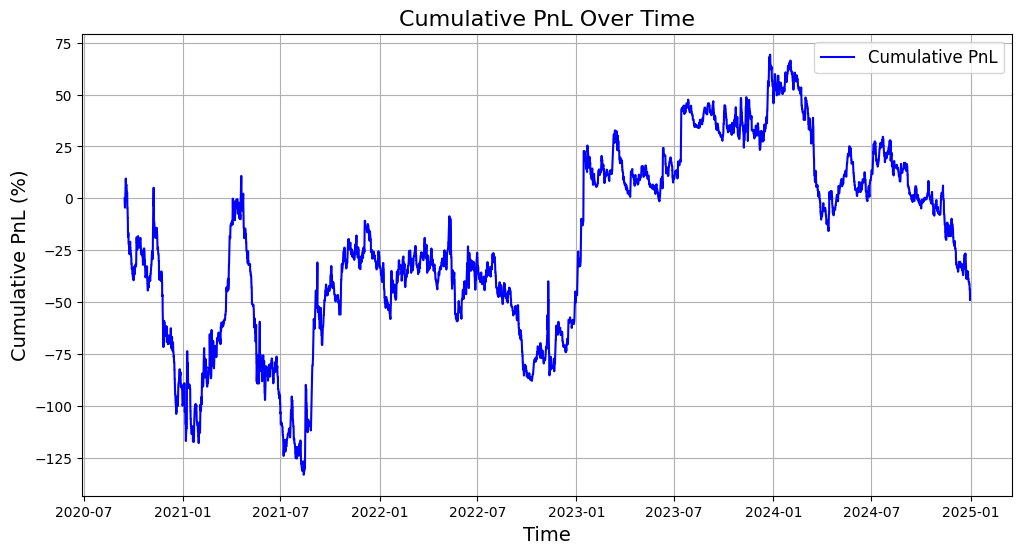

In [18]:
import matplotlib.pyplot as plt

# Convert 'time' column to datetime for plotting
backtest_recap['time'] = pd.to_datetime(backtest_recap['time'], unit='ms')

# Plot cumulative PnL over time
plt.figure(figsize=(12, 6))
plt.plot(backtest_recap['time'], backtest_recap['cum_pnl'], label='Cumulative PnL', color='blue')
plt.title('Cumulative PnL Over Time', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Cumulative PnL (%)', fontsize=14)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()

# 2 Stacked Super Trend